<a href="https://colab.research.google.com/github/zwubbena/edfacts-dispute_resolution/blob/main/edfacts_dispute_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDFacts IDEA Part B Dispute Resolution**

## EDFacts Submissions in EDPass

EDFacts Dispute Resolution data submissions in EDPass for the 2024-25 school year include four file specification (FS) documents:

- **FS227** – IDEA Part B Dispute Resolution Written, Signed Complaints
- **FS228** – IDEA Part B Dispute Resolution Mediation Requests
- **FS229** – IDEA Part B Dispute Resolution Due Process Complaints
- **FS230** – IDEA Part B Dispute Resolution Expedited Due Process Complaints


**EDPass as a Submission Platform:** EDPass is the primary system used by State Education Agencies (SEAs) to upload and submit EDFacts data, including dispute resolution data, to the U.S. Department of Education. The new file specification documents were published in May 2025.

## State Performance Plan Indicators (SPPI)

The EDFacts data map to the two indicators in the State Performance Plan/Annual Performance Report (SPP/APR).

- **SPPI 15** - Resolution Sessions. % of hearing requests that went to resolution sessions that were resolved through resolution session settlement agreements.
- **SPPI 16** -  Mediation. % of mediations held resulting in mediation agreements.




## Workflow

> **LEAs -> CDRMS -> EDFacts -> EDPass -> SPP/APR -> SEA Determination**

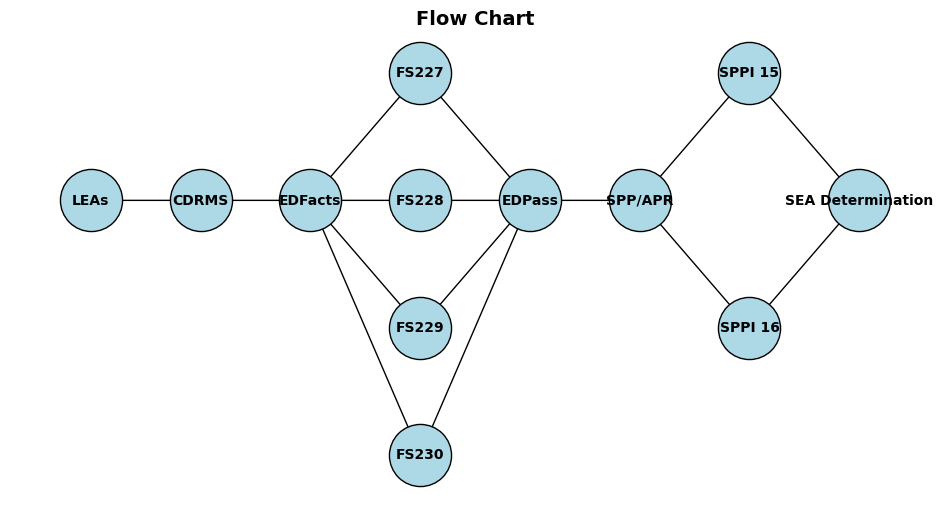

Paste this into a Markdown cell to embed the saved image:

![Flow Chart](flowchart.png)


In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Define the edges for the flow
edges = [
    ("LEAs", "CDRMS"),
    ("CDRMS", "EDFacts"),
    ("EDFacts", "FS227"),
    ("FS227", "EDPass"),
    ("EDFacts", "FS228"),
    ("FS228", "EDPass"),
    ("EDFacts", "FS229"),
    ("FS229", "EDPass"),
    ("EDFacts", "FS230"),
    ("FS230", "EDPass"),
    ("EDPass", "SPP/APR"),
    ("SPP/APR", "SPPI 15"),
    ("SPP/APR", "SPPI 16"),
    ("SPPI 15", "SEA Determination"),
    ("SPPI 16", "SEA Determination")
]

# Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Manual positioning for flowchart layout
pos = {
    "LEAs": (0, 5),
    "CDRMS": (2, 5),
    "EDFacts": (4, 5),
    "FS227": (6, 6),
    "FS228": (6, 5),
    "FS229": (6, 4),
    "FS230": (6, 3),
    "EDPass": (8, 5),
    "SPP/APR": (10, 5),
    "SPPI 15": (12, 6),
    "SPPI 16": (12, 4),
    "SEA Determination": (14, 5)
}

# Plot the flowchart
plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000, edgecolors='black')
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.axis('off')
plt.title("Flow Chart", fontsize=14, fontweight='bold')

# Save the chart as a PNG
plt.savefig("flowchart.png", bbox_inches="tight")
plt.show()

# Print Markdown link for embedding
print("Paste this into a Markdown cell to embed the saved image:\n")
print("![Flow Chart](flowchart.png)")


# **Python Scripts**

## FS227 – Written, Signed Complaints

In [ ]:
"""
PROGRAM:  fs227_written_signed_complaints.py
PURPOSE:  Import legacy SECTION/COUNT, create FS227 Header/Data tables via IF-THEN-DO,
          then write the EDPass CSV (header record + data records; no column-name row).
DATE:     2025-08-10
AUTHOR:   Zane Wubbena, PhD
CONTACT   zane.wubbena@tea.texas.gov
INPUT:    CSV with columns: SECTION, COUNT
OUTPUT:   UTF-8, CRLF CSV for EDPass (FS227 table: IDEABDISPRESWSC)

RULES:
  - Include all 7 required detail rows (1.1, 1.2, 1.3, 1.1(a), 1.1(b), 1.1(c), 1.2(a)).
  - Use 0 for true zeros; use -1 for missing/unknown.
  - EUT (Total): sum of 1.1 + 1.2 + 1.3 unless any is -1 → then EUT = -1.
  - Exactly one WSC* category column populated per detail row; EUT has all category columns blank.
"""

import pandas as pd
import numpy as np
from io import StringIO
from google.colab import files
import os

# =========================
# Step 0: Configuration
# =========================

# Configuration parameters
CONFIG = {
    'OUT_FILE': 'txseaIDEABDWSCv000001.csv',  # must match header File Name (<=25 chars)
    'FILE_ID': 'FS227_TX_FFY2024_SY2425_V001',  # File Identifier (<=32 chars)
    'REPORT_PERIOD': '2024-2025',  # CCYY-CCYY
    'STATE_CODE': 48,  # DG559 ANSI (2-digit, zero-padded)
    'STATE_AGENCY': 1,  # DG570 (SEA=01)
    'TABLE_NAME': 'IDEABDISPRESWSC',  # technical table name
}

# Explanations used in Data Records
EXPLANATIONS = {
    'STATUS_ISSUED': 'Written, Signed Complaints with reports issued as of 60 days following the end of the reporting period.',
    'STATUS_PENDING': 'Written, Signed Complaints with reports pending as of 60 days following the end of the reporting period.',
    'STATUS_WD_DISM': 'Written, Signed Complaints withdrawn or dismissed as of 60 days following the end of the reporting period.',
    'FINDINGS_NC': 'Reports issued as of 60 days following the end of the reporting period with findings of noncompliance',
    'TL_WITHIN': 'Reports issued as of 60 days following the end of the reporting period within the timelines (60 days)',
    'TL_EXTENDED': 'Reports issued as of 60 days following the end of the reporting period within extended timelines',
    'PEND_DPH': 'Written, Signed Complaints with reports pending as of 60 days following the end of the reporting period that are pending a due process hearing.',
    'TOTAL': 'Total written, signed complaints.',
}

# =========================
# Step 0a: Guards
# =========================

def validate_config():
    """Validate configuration parameters meet length requirements."""
    if len(CONFIG['FILE_ID']) > 32:
        raise ValueError(f"FILE_ID exceeds 32 characters: {CONFIG['FILE_ID']}, length={len(CONFIG['FILE_ID'])} (max=32)")

    if len(CONFIG['OUT_FILE']) > 25:
        raise ValueError(f"OUT_FILE exceeds 25 characters: {CONFIG['OUT_FILE']}, length={len(CONFIG['OUT_FILE'])} (max=25)")

# =========================
# Step 1: Create Test Data
# =========================

def create_test_data():
    """Create the test dataset shown in the image."""
    test_data = """SECTION,COUNT
Legacy 1.1,650
Legacy 1.2,21
Legacy 1.3,522
Legacy 1.1(a),386
Legacy 1.1(b),629
Legacy 1.1(c),21
Legacy 1.2(a),20"""

    return pd.read_csv(StringIO(test_data))

# =========================
# Step 2: Process Data
# =========================

def normalize_data(df):
    """Normalize SECTION text and coerce COUNT to numeric; enforce -1 for missing/negative."""
    df = df.copy()
    df['SECTION'] = df['SECTION'].str.strip()

    # Coerce COUNT to numeric
    df['COUNT'] = pd.to_numeric(df['COUNT'], errors='coerce')

    # Replace missing or negative values with -1
    df.loc[df['COUNT'].isna() | (df['COUNT'] < 0), 'COUNT'] = -1

    # Round to integers
    df['COUNT'] = df['COUNT'].round(0).astype(int)

    return df

def build_data_records(df):
    """Build data records (detail) with IF-THEN-DO logic."""
    records = []

    # Track which required sections appeared
    found_sections = {
        '1.1': False,
        '1.2': False,
        '1.3': False,
        '1.1(a)': False,
        '1.1(b)': False,
        '1.1(c)': False,
        '1.2(a)': False
    }

    # Track sum/missing for EUT
    sum_status = 0
    any_missing = False

    # Process each row in the input data
    for _, row in df.iterrows():
        section = row['SECTION']
        count = row['COUNT']

        record = {
            'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
            'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
            'Filler1': '',
            'Filler2': '',
            'Table_Name': CONFIG['TABLE_NAME'],
            'Filler3': '',
            'WSC_Status': '',
            'WSC_Findings': '',
            'WSC_Timelines': '',
            'WSC_Pending_Type': '',
            'Total_Indicator': 'N',
            'Explanation': '',
            'WSC_Count': count
        }

        # Map SECTION → category/value
        if section == 'Legacy 1.1':
            found_sections['1.1'] = True
            record['WSC_Status'] = 'CMPLNTSRPTISSD'
            record['Explanation'] = EXPLANATIONS['STATUS_ISSUED']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'Legacy 1.2':
            found_sections['1.2'] = True
            record['WSC_Status'] = 'CMPLNTSPNDG'
            record['Explanation'] = EXPLANATIONS['STATUS_PENDING']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'Legacy 1.3':
            found_sections['1.3'] = True
            record['WSC_Status'] = 'CMPLNTSWDRNDIS'
            record['Explanation'] = EXPLANATIONS['STATUS_WD_DISM']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'Legacy 1.1(a)':
            found_sections['1.1(a)'] = True
            record['WSC_Findings'] = 'RPTSWFNDGSNC'
            record['Explanation'] = EXPLANATIONS['FINDINGS_NC']
            records.append(record)

        elif section == 'Legacy 1.1(b)':
            found_sections['1.1(b)'] = True
            record['WSC_Timelines'] = 'RPTSWTHNTMLNS'
            record['Explanation'] = EXPLANATIONS['TL_WITHIN']
            records.append(record)

        elif section == 'Legacy 1.1(c)':
            found_sections['1.1(c)'] = True
            record['WSC_Timelines'] = 'RPTSWTHNXTMLNS'
            record['Explanation'] = EXPLANATIONS['TL_EXTENDED']
            records.append(record)

        elif section == 'Legacy 1.2(a)':
            found_sections['1.2(a)'] = True
            record['WSC_Pending_Type'] = 'CMPLNTSPNDGDPH'
            record['Explanation'] = EXPLANATIONS['PEND_DPH']
            records.append(record)

    # Add any missing required sections with WSC_Count = -1
    missing_mappings = {
        '1.1': ('WSC_Status', 'CMPLNTSRPTISSD', 'STATUS_ISSUED'),
        '1.2': ('WSC_Status', 'CMPLNTSPNDG', 'STATUS_PENDING'),
        '1.3': ('WSC_Status', 'CMPLNTSWDRNDIS', 'STATUS_WD_DISM'),
        '1.1(a)': ('WSC_Findings', 'RPTSWFNDGSNC', 'FINDINGS_NC'),
        '1.1(b)': ('WSC_Timelines', 'RPTSWTHNTMLNS', 'TL_WITHIN'),
        '1.1(c)': ('WSC_Timelines', 'RPTSWTHNXTMLNS', 'TL_EXTENDED'),
        '1.2(a)': ('WSC_Pending_Type', 'CMPLNTSPNDGDPH', 'PEND_DPH')
    }

    for section_key, found in found_sections.items():
        if not found:
            if section_key in ['1.1', '1.2', '1.3']:
                any_missing = True

            cat_field, cat_value, expl_key = missing_mappings[section_key]
            record = {
                'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
                'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
                'Filler1': '',
                'Filler2': '',
                'Table_Name': CONFIG['TABLE_NAME'],
                'Filler3': '',
                'WSC_Status': '',
                'WSC_Findings': '',
                'WSC_Timelines': '',
                'WSC_Pending_Type': '',
                'Total_Indicator': 'N',
                'Explanation': EXPLANATIONS[expl_key],
                'WSC_Count': -1
            }
            record[cat_field] = cat_value
            records.append(record)

    # Add Education Unit Total (EUT) row
    eut_record = {
        'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
        'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
        'Filler1': '',
        'Filler2': '',
        'Table_Name': CONFIG['TABLE_NAME'],
        'Filler3': '',
        'WSC_Status': '',
        'WSC_Findings': '',
        'WSC_Timelines': '',
        'WSC_Pending_Type': '',
        'Total_Indicator': 'Y',
        'Explanation': EXPLANATIONS['TOTAL'],
        'WSC_Count': -1 if any_missing else sum_status
    }
    records.append(eut_record)

    # Create DataFrame and add File_Record_Number
    df_records = pd.DataFrame(records)
    df_records.insert(0, 'File_Record_Number', range(1, len(df_records) + 1))

    return df_records

def create_header_record(n_records):
    """Create the header record (1 row)."""
    header = {
        'File_Type': 'SEA PART B DISPUTE COMPLAINTS',
        'Total_Records_in_File': n_records,
        'File_Name': CONFIG['OUT_FILE'],
        'File_Identifier': CONFIG['FILE_ID'],
        'File_Reporting_Period': CONFIG['REPORT_PERIOD'],
        'Filler': ''
    }
    return pd.DataFrame([header])

def write_csv(header_df, data_df, filename):
    """Write final CSV (values only; no column headers)."""
    # Write header row
    header_csv = header_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Write data rows
    data_csv = data_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Combine
    final_csv = header_csv + data_csv

    # Save to file
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        f.write(final_csv)

    return final_csv

# =========================
# Main Execution
# =========================

def main():
    """Main execution function."""
    print("FS227 IF-THEN Build Script")
    print("=" * 50)

    # Validate configuration
    validate_config()
    print("✓ Configuration validated")

    # Option 1: Use test data (comment out if uploading file)
    print("\nUsing test data from the example...")
    df_input = create_test_data()

    # Option 2: Upload file (uncomment to use)
    # print("\nPlease upload your input CSV file...")
    # uploaded = files.upload()
    # filename = list(uploaded.keys())[0]
    # df_input = pd.read_csv(filename)

    print(f"\nInput data shape: {df_input.shape}")
    print("\nInput data preview:")
    print(df_input)

    # Step 1: Normalize data
    df_normalized = normalize_data(df_input)
    print("\n✓ Data normalized")

    # Step 2: Build data records
    df_data = build_data_records(df_normalized)
    print(f"✓ Data records built: {len(df_data)} rows")

    # Step 3: Create header record
    df_header = create_header_record(len(df_data))
    print("✓ Header record created")

    # Step 4: Write CSV
    output_filename = CONFIG['OUT_FILE']
    write_csv(df_header, df_data, output_filename)
    print(f"\n✓ CSV file written: {output_filename}")

    # Display results
    print("\n" + "=" * 50)
    print("HEADER RECORD:")
    print(df_header.to_string(index=False))

    print("\n" + "=" * 50)
    print("DATA RECORDS:")
    print(df_data.to_string(index=False))

    # QA Summary
    print("\n" + "=" * 50)
    print("QA SUMMARY:")
    print(f"Total records: {len(df_data)}")
    print(f"Detail records (Total_Indicator='N'): {len(df_data[df_data['Total_Indicator'] == 'N'])}")
    print(f"EUT record (Total_Indicator='Y'): {len(df_data[df_data['Total_Indicator'] == 'Y'])}")

    # Download the file
    print("\n" + "=" * 50)
    print("Downloading output file...")
    files.download(output_filename)

    return df_header, df_data

# Run the main function
if __name__ == "__main__":
    header_df, data_df = main()

# =========================
#  Python Program End
# ===========================

FS227 IF-THEN Build Script
✓ Configuration validated

Using test data from the example...

Input data shape: (7, 2)

Input data preview:
         SECTION  COUNT
0     Legacy 1.1    650
1     Legacy 1.2     21
2     Legacy 1.3    522
3  Legacy 1.1(a)    386
4  Legacy 1.1(b)    629
5  Legacy 1.1(c)     21
6  Legacy 1.2(a)     20

✓ Data normalized
✓ Data records built: 8 rows
✓ Header record created

✓ CSV file written: txseaIDEABDWSCv000001.csv

HEADER RECORD:
                    File_Type  Total_Records_in_File                 File_Name              File_Identifier File_Reporting_Period Filler
SEA PART B DISPUTE COMPLAINTS                      8 txseaIDEABDWSCv000001.csv FS227_TX_FFY2024_SY2425_V001             2024-2025       

DATA RECORDS:
 File_Record_Number DG559_State_Code DG570_State_Agency_Number Filler1 Filler2      Table_Name Filler3     WSC_Status WSC_Findings  WSC_Timelines WSC_Pending_Type Total_Indicator                                                                     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## FS228 – Mediation Requests

In [ ]:
"""
PROGRAM:  fs228_mediation_requests.py
PURPOSE:  Import legacy SECTION/COUNT, create FS228 Header/Data tables via IF-THEN-DO,
          then write the EDPass CSV (header record + data records; no column-name row).
DATE:     2025-08-10
AUTHOR:   Zane Wubbena, PhD
CONTACT   zane.wubbena@tea.texas.gov
INPUT:    CSV with columns: SECTION, COUNT
OUTPUT:   UTF-8, CRLF CSV for EDPass (FS228 table: IDEABDISPRESMEDREQ)

RULES:
  - Required detail rows (7 total):
      * Status (3): 2.1 -> MEDTNHLD; 2.2 -> MEDTNPND; 2.3 -> MEDTNWTHDRW
      * Type   (2): 2.1(a) -> MEDTNHLDDPH; 2.1(b) -> MEDTNHLDNODPH
      * Type×Outcome (2): 2.1(a)(i) -> MEDTNHLDDPH + MEDTNAGRMNT
                          2.1(b)(i) -> MEDTNHLDNODPH + MEDTNAGRMNT
  - Use 0 for true zeros; use -1 for missing/unknown.
  - EUT (Total): sum of MEDTNHLD + MEDTNPND + MEDTNWTHDRW unless any is -1 → then EUT = -1.
  - Exactly one category column populated per detail row (except the Type×Outcome rows, which have both Type and Outcome).
"""

import pandas as pd
import numpy as np
from io import StringIO
from google.colab import files
import os

# =========================
# Step 0: Configuration
# =========================

# Configuration parameters
CONFIG = {
    'OUT_FILE': 'txseaIDEABDMRv000001.csv',  # must match header File Name (<=25 chars)
    'FILE_ID': 'FS228_TX_FFY2024_SY2425_V001',  # File Identifier (<=32 chars)
    'REPORT_PERIOD': '2024-2025',  # CCYY-CCYY
    'STATE_CODE': 48,  # DG559 ANSI (2-digit, zero-padded)
    'STATE_AGENCY': 1,  # DG570 (SEA=01)
    'TABLE_NAME': 'IDEABDISPRESMEDREQ',  # FS228 technical table name
}

# Explanations used in Data Records
EXPLANATIONS = {
    'STATUS_HELD': 'Mediation requests resulting in mediations held as of the end of the reporting period.',
    'STATUS_PEND': 'Mediations pending as of the end of the reporting period (including mediation requests pending).',
    'STATUS_WDNH': 'Mediation requests withdrawn or not held as of the end of the reporting period.',
    'TYPE_DPH': 'Mediations held that were related to due process complaints.',
    'TYPE_NODPH': 'Mediations held that were not related to due process complaints.',
    'AGRMNT_DPH': 'Mediations held related to due process complaints that ended with a mediation agreement.',
    'AGRMNT_NODPH': 'Mediations held not related to due process complaints that ended with a mediation agreement.',
    'TOTAL': 'Total mediation requests.',
}

# =========================
# Step 0a: Guards
# =========================

def validate_config():
    """Validate configuration parameters meet length requirements."""
    if len(CONFIG['FILE_ID']) > 32:
        raise ValueError(f"FILE_ID exceeds 32 characters: {CONFIG['FILE_ID']}, length={len(CONFIG['FILE_ID'])} (max=32)")

    if len(CONFIG['OUT_FILE']) > 25:
        raise ValueError(f"OUT_FILE exceeds 25 characters: {CONFIG['OUT_FILE']}, length={len(CONFIG['OUT_FILE'])} (max=25)")

# =========================
# Step 1: Create Test Data
# =========================

def create_test_data():
    """Create comprehensive test dataset for FS228 with various scenarios."""
    test_data = """SECTION,COUNT
Legacy 2.1,258
Legacy 2.2,121
Legacy 2.3,50
Legacy 2.1(a),168
Legacy 2.1(b),90
Legacy 2.1(a)(i),112
Legacy 2.1(b)(i),56"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_missing():
    """Create test dataset with missing sections to test gap-filling logic."""
    test_data = """SECTION,COUNT
Legacy 2.1,258
Legacy 2.3,50
Legacy 2.1(b),90
Legacy 2.1(a)(i),112"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_negatives():
    """Create test dataset with negative/missing values to test -1 handling."""
    test_data = """SECTION,COUNT
Legacy 2.1,-5
Legacy 2.2,
Legacy 2.3,50
Legacy 2.1(a),168
Legacy 2.1(b),90
Legacy 2.1(a)(i),112
Legacy 2.1(b)(i),"""

    return pd.read_csv(StringIO(test_data))

# =========================
# Step 2: Process Data
# =========================

def normalize_data(df):
    """
    Normalize SECTION text and coerce COUNT to numeric.
    Aggregate duplicates by SECTION (sum).
    Enforce -1 for missing/negative values.
    """
    df = df.copy()

    # Normalize SECTION to uppercase and strip whitespace
    df['SECTION'] = df['SECTION'].str.strip().str.upper()

    # Coerce COUNT to numeric
    df['COUNT'] = pd.to_numeric(df['COUNT'], errors='coerce')

    # Aggregate by SECTION (sum duplicates)
    df = df.groupby('SECTION', as_index=False)['COUNT'].sum()

    # Replace missing or negative values with -1
    df.loc[df['COUNT'].isna() | (df['COUNT'] < 0), 'COUNT'] = -1

    # Round to integers
    df['COUNT'] = df['COUNT'].round(0).astype(int)

    return df

def build_data_records(df):
    """Build data records (detail) with IF-THEN-DO logic for FS228."""
    records = []

    # Track which required sections appeared
    found_sections = {
        'stat_21': False,   # Legacy 2.1
        'stat_22': False,   # Legacy 2.2
        'stat_23': False,   # Legacy 2.3
        'typ_21a': False,   # Legacy 2.1(a)
        'typ_21b': False,   # Legacy 2.1(b)
        'out_21ai': False,  # Legacy 2.1(a)(i)
        'out_21bi': False,  # Legacy 2.1(b)(i)
    }

    # Track sum/missing for EUT (only Status rows contribute to total)
    sum_status = 0
    any_missing = False

    # Process each row in the input data
    for _, row in df.iterrows():
        section = row['SECTION']
        count = row['COUNT']

        # Base record structure
        record = {
            'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
            'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
            'Filler1': '',
            'Filler2': '',
            'Table_Name': CONFIG['TABLE_NAME'],
            'Filler3': '',
            'MR_Status': '',
            'MR_Type': '',
            'MR_Outcome': '',
            'Total_Indicator': 'N',
            'Explanation': '',
            'MR_Count': count
        }

        # Map SECTION → category/value based on SAS logic
        if section == 'LEGACY 2.1':
            found_sections['stat_21'] = True
            record['MR_Status'] = 'MEDTNHLD'
            record['Explanation'] = EXPLANATIONS['STATUS_HELD']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 2.2':
            found_sections['stat_22'] = True
            record['MR_Status'] = 'MEDTNPND'
            record['Explanation'] = EXPLANATIONS['STATUS_PEND']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 2.3':
            found_sections['stat_23'] = True
            record['MR_Status'] = 'MEDTNWTHDRW'
            record['Explanation'] = EXPLANATIONS['STATUS_WDNH']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 2.1(A)':
            found_sections['typ_21a'] = True
            record['MR_Type'] = 'MEDTNHLDDPH'
            record['Explanation'] = EXPLANATIONS['TYPE_DPH']
            records.append(record)

        elif section == 'LEGACY 2.1(B)':
            found_sections['typ_21b'] = True
            record['MR_Type'] = 'MEDTNHLDNODPH'
            record['Explanation'] = EXPLANATIONS['TYPE_NODPH']
            records.append(record)

        elif section == 'LEGACY 2.1(A)(I)':
            found_sections['out_21ai'] = True
            record['MR_Type'] = 'MEDTNHLDDPH'
            record['MR_Outcome'] = 'MEDTNAGRMNT'
            record['Explanation'] = EXPLANATIONS['AGRMNT_DPH']
            records.append(record)

        elif section == 'LEGACY 2.1(B)(I)':
            found_sections['out_21bi'] = True
            record['MR_Type'] = 'MEDTNHLDNODPH'
            record['MR_Outcome'] = 'MEDTNAGRMNT'
            record['Explanation'] = EXPLANATIONS['AGRMNT_NODPH']
            records.append(record)

        # Otherwise ignore unmapped sections (could log if desired)

    # Add any missing required sections with MR_Count = -1

    # Status rows (3) - these affect the EUT calculation
    if not found_sections['stat_21']:
        any_missing = True
        record = create_base_record()
        record['MR_Status'] = 'MEDTNHLD'
        record['Explanation'] = EXPLANATIONS['STATUS_HELD']
        record['MR_Count'] = -1
        records.append(record)

    if not found_sections['stat_22']:
        any_missing = True
        record = create_base_record()
        record['MR_Status'] = 'MEDTNPND'
        record['Explanation'] = EXPLANATIONS['STATUS_PEND']
        record['MR_Count'] = -1
        records.append(record)

    if not found_sections['stat_23']:
        any_missing = True
        record = create_base_record()
        record['MR_Status'] = 'MEDTNWTHDRW'
        record['Explanation'] = EXPLANATIONS['STATUS_WDNH']
        record['MR_Count'] = -1
        records.append(record)

    # Type rows (2) - these don't affect the EUT calculation
    if not found_sections['typ_21a']:
        record = create_base_record()
        record['MR_Type'] = 'MEDTNHLDDPH'
        record['Explanation'] = EXPLANATIONS['TYPE_DPH']
        record['MR_Count'] = -1
        records.append(record)

    if not found_sections['typ_21b']:
        record = create_base_record()
        record['MR_Type'] = 'MEDTNHLDNODPH'
        record['Explanation'] = EXPLANATIONS['TYPE_NODPH']
        record['MR_Count'] = -1
        records.append(record)

    # Type×Outcome rows (2) - both Type and Outcome populated
    if not found_sections['out_21ai']:
        record = create_base_record()
        record['MR_Type'] = 'MEDTNHLDDPH'
        record['MR_Outcome'] = 'MEDTNAGRMNT'
        record['Explanation'] = EXPLANATIONS['AGRMNT_DPH']
        record['MR_Count'] = -1
        records.append(record)

    if not found_sections['out_21bi']:
        record = create_base_record()
        record['MR_Type'] = 'MEDTNHLDNODPH'
        record['MR_Outcome'] = 'MEDTNAGRMNT'
        record['Explanation'] = EXPLANATIONS['AGRMNT_NODPH']
        record['MR_Count'] = -1
        records.append(record)

    # Add Education Unit Total (EUT) row
    eut_record = create_base_record()
    eut_record['Total_Indicator'] = 'Y'
    eut_record['Explanation'] = EXPLANATIONS['TOTAL']
    eut_record['MR_Count'] = -1 if any_missing else sum_status
    records.append(eut_record)

    # Create DataFrame and add File_Record_Number
    df_records = pd.DataFrame(records)
    df_records.insert(0, 'File_Record_Number', range(1, len(df_records) + 1))

    return df_records

def create_base_record():
    """Create a base record with all fields initialized."""
    return {
        'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
        'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
        'Filler1': '',
        'Filler2': '',
        'Table_Name': CONFIG['TABLE_NAME'],
        'Filler3': '',
        'MR_Status': '',
        'MR_Type': '',
        'MR_Outcome': '',
        'Total_Indicator': 'N',
        'Explanation': '',
        'MR_Count': 0
    }

def create_header_record(n_records):
    """Create the header record (1 row) for FS228."""
    header = {
        'File_Type': 'SEA PART B MED REQ',  # FS228 specific header
        'Total_Records_in_File': n_records,
        'File_Name': CONFIG['OUT_FILE'],
        'File_Identifier': CONFIG['FILE_ID'],
        'File_Reporting_Period': CONFIG['REPORT_PERIOD'],
        'Filler': ''
    }
    return pd.DataFrame([header])

def write_csv(header_df, data_df, filename):
    """Write final CSV (values only; no column headers)."""
    # Write header row
    header_csv = header_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Write data rows
    data_csv = data_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Combine
    final_csv = header_csv + data_csv

    # Save to file
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        f.write(final_csv)

    return final_csv

# =========================
# Main Execution
# =========================

def main(test_scenario='complete'):
    """
    Main execution function.

    Args:
        test_scenario: Which test dataset to use
            - 'complete': All sections present with valid data
            - 'missing': Some sections missing to test gap-filling
            - 'negatives': Test handling of negative/missing values
            - 'upload': Upload your own file
    """
    print("FS228 Mediation Requests Build Script")
    print("=" * 50)

    # Validate configuration
    validate_config()
    print("✓ Configuration validated")

    # Select test data based on scenario
    if test_scenario == 'complete':
        print("\nUsing COMPLETE test data (all sections present)...")
        df_input = create_test_data()
    elif test_scenario == 'missing':
        print("\nUsing test data with MISSING sections...")
        df_input = create_test_data_with_missing()
    elif test_scenario == 'negatives':
        print("\nUsing test data with NEGATIVE/MISSING values...")
        df_input = create_test_data_with_negatives()
    elif test_scenario == 'upload':
        print("\nPlease upload your input CSV file...")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        df_input = pd.read_csv(filename)
    else:
        print(f"\nUnknown scenario '{test_scenario}'. Using complete test data...")
        df_input = create_test_data()

    print(f"\nInput data shape: {df_input.shape}")
    print("\nInput data preview:")
    print(df_input)

    # Step 1: Normalize data
    df_normalized = normalize_data(df_input)
    print("\n✓ Data normalized")
    print("\nNormalized data:")
    print(df_normalized)

    # Step 2: Build data records
    df_data = build_data_records(df_normalized)
    print(f"\n✓ Data records built: {len(df_data)} rows")

    # Step 3: Create header record
    df_header = create_header_record(len(df_data))
    print("✓ Header record created")

    # Step 4: Write CSV
    output_filename = CONFIG['OUT_FILE']
    write_csv(df_header, df_data, output_filename)
    print(f"\n✓ CSV file written: {output_filename}")

    # Display results
    print("\n" + "=" * 50)
    print("HEADER RECORD:")
    print(df_header.to_string(index=False))

    print("\n" + "=" * 50)
    print("DATA RECORDS:")
    print(df_data.to_string(index=False))

    # QA Summary
    print("\n" + "=" * 50)
    print("QA SUMMARY:")
    print(f"Total records: {len(df_data)}")
    print(f"Detail records (Total_Indicator='N'): {len(df_data[df_data['Total_Indicator'] == 'N'])}")
    print(f"EUT record (Total_Indicator='Y'): {len(df_data[df_data['Total_Indicator'] == 'Y'])}")

    # Category distribution
    print("\nCategory Distribution:")
    print(f"MR_Status populated: {len(df_data[df_data['MR_Status'] != ''])} rows")
    print(f"MR_Type populated: {len(df_data[df_data['MR_Type'] != ''])} rows")
    print(f"MR_Outcome populated: {len(df_data[df_data['MR_Outcome'] != ''])} rows")

    # Value distribution
    print("\nMR_Count Distribution:")
    print(df_data['MR_Count'].value_counts().sort_index())

    # Download the file
    print("\n" + "=" * 50)
    print("Downloading output file...")
    files.download(output_filename)

    return df_header, df_data

# Run the main function with different test scenarios
if __name__ == "__main__":
    # Choose which test scenario to run:
    # 'complete' - all sections with valid data
    # 'missing' - some sections missing
    # 'negatives' - test -1 handling
    # 'upload' - upload your own file

    header_df, data_df = main(test_scenario='complete')

    # Uncomment to test other scenarios:
    # header_df, data_df = main(test_scenario='missing')
    # header_df, data_df = main(test_scenario='negatives')
    # header_df, data_df = main(test_scenario='upload')

# =========================
#  Python Program End
# =========================


FS228 Mediation Requests Build Script
✓ Configuration validated

Using COMPLETE test data (all sections present)...

Input data shape: (7, 2)

Input data preview:
            SECTION  COUNT
0        Legacy 2.1     25
1        Legacy 2.2      8
2        Legacy 2.3      3
3     Legacy 2.1(a)     12
4     Legacy 2.1(b)     13
5  Legacy 2.1(a)(i)     10
6  Legacy 2.1(b)(i)     11

✓ Data normalized

Normalized data:
            SECTION  COUNT
0        LEGACY 2.1     25
1     LEGACY 2.1(A)     12
2  LEGACY 2.1(A)(I)     10
3     LEGACY 2.1(B)     13
4  LEGACY 2.1(B)(I)     11
5        LEGACY 2.2      8
6        LEGACY 2.3      3

✓ Data records built: 8 rows
✓ Header record created

✓ CSV file written: txseaIDEABDMRv000001.csv

HEADER RECORD:
         File_Type  Total_Records_in_File                File_Name              File_Identifier File_Reporting_Period Filler
SEA PART B MED REQ                      8 txseaIDEABDMRv000001.csv FS228_TX_FFY2024_SY2425_V001             2024-2025       

D

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## FS229 – Due Process Complaints

In [ ]:
"""
PROGRAM:  fs229_due_process_complaints.py
PURPOSE:  Import legacy SECTION/COUNT, create FS229 Header/Data tables via IF-THEN-DO,
          then write the EDPass CSV (header record + data records; no column-name row).
DATE:     2025-08-10
AUTHOR:   Zane Wubbena, PhD
CONTACT   zane.wubbena@tea.texas.gov
INPUT:    CSV with columns: SECTION, COUNT
OUTPUT:   UTF-8, CRLF CSV for EDPass (FS229 table: IDEABDISPRESDPC)

SPEC BASIS: FS229 v21.0 (SY 2024-25)
  - File Type: "SEA PART B DUE PROCESS COMPLAINTS"
  - Table Name: IDEABDISPRESDPC
  - Naming token (filename): IDEABDPC
  - Category sets & permitted values:
      * Due Process Complaint Status (Set A): HRNGADJCTD, DPCPND, DPCWTHDRW
      * Hearings Fully Adjudicated Outcome (Set B): DCSNSWTHNTMLN, DCSNWNEXTTMLN
      * Resolution Meeting Outcome (Set C): WRTNSTLAGRMNT
      * Due Process Complaint Result (Set D): RSLTNMTG
  - EUT = HRNGADJCTD + DPCPND + DPCWTHDRW, unless any is -1 → EUT = -1.
  - Total_Indicator = 'N' for category sets A–D; 'Y' for EUT.

RULES:
  - Use 0 for true zeros; use -1 for missing/unknown.
  - Exactly one category column populated per detail row; EUT has all category columns blank.
  - Legacy → FS229 crosswalk:
      "Legacy 3.2"     → DPC_Status=HRNGADJCTD
      "Legacy 3.2(a)"  → HRNG_Outcome=DCSNSWTHNTMLN
      "Legacy 3.2(b)"  → HRNG_Outcome=DCSNWNEXTTMLN
      "Legacy 3.3"     → DPC_Status=DPCPND
      "Legacy 3.4"     → DPC_Status=DPCWTHDRW
      "Legacy 3.1"     → DPC_Result=RSLTNMTG
      "Legacy 3.1(a)"  → RSLTN_Outcome=WRTNSTLAGRMNT
"""

import pandas as pd
import numpy as np
from io import StringIO
from google.colab import files
import os

# =========================
# Step 0: Configuration
# =========================

# Configuration parameters
CONFIG = {
    'OUT_FILE': 'txseaIDEABDPCv000001.csv',  # must match header File Name (<=25 chars)
    'FILE_ID': 'FS229_TX_FFY2024_SY2425_V001',  # File Identifier (<=32 chars)
    'REPORT_PERIOD': '2024-2025',  # CCYY-CCYY
    'STATE_CODE': 48,  # DG559 ANSI (2-digit, zero-padded)
    'STATE_AGENCY': 1,  # DG570 (SEA=01)
    'TABLE_NAME': 'IDEABDISPRESDPC',  # FS229 technical table name
}

# Explanations used in Data Records
EXPLANATIONS = {
    'STAT_ADJ': 'Due process complaints resulting in hearings fully adjudicated as of the end of the reporting period.',
    'STAT_PND': 'Due process complaints pending as of the end of the reporting period.',
    'STAT_WD': 'Due process complaints withdrawn or dismissed as of the end of the reporting period.',
    'OUT_WTLN': 'Hearings fully adjudicated with decisions within the timeline.',
    'OUT_XTLN': 'Hearings fully adjudicated with decisions within extended timeline.',
    'RES_TOTAL': 'Due process complaints that resulted in resolution meetings by the end of the reporting period.',
    'RES_WSA': 'Resolution meetings that resulted in written settlement agreements by the end of the reporting period.',
    'TOTAL': 'Total due process complaints.',
}

# =========================
# Step 0a: Guards
# =========================

def validate_config():
    """Validate configuration parameters meet length requirements."""
    if len(CONFIG['FILE_ID']) > 32:
        raise ValueError(f"FILE_ID exceeds 32 characters: {CONFIG['FILE_ID']}, length={len(CONFIG['FILE_ID'])} (max=32)")

    if len(CONFIG['OUT_FILE']) > 25:
        raise ValueError(f"OUT_FILE exceeds 25 characters: {CONFIG['OUT_FILE']}, length={len(CONFIG['OUT_FILE'])} (max=25)")

# =========================
# Step 1: Create Test Data
# =========================

def create_test_data():
    """Create comprehensive test dataset for FS229 with all sections present."""
    test_data = """SECTION,COUNT
Legacy 3.2,16
Legacy 3.3,116
Legacy 3.4,291
Legacy 3.2(a),4
Legacy 3.2(b),12
Legacy 3.1,146
Legacy 3.1(a),57"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_missing():
    """Create test dataset with missing sections to test gap-filling logic."""
    test_data = """SECTION,COUNT
Legacy 3.2,16
Legacy 3.4,292
Legacy 3.2(b),12
Legacy 3.1(a),57"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_negatives():
    """Create test dataset with negative/missing values to test -1 handling."""
    test_data = """SECTION,COUNT
Legacy 3.2,-16
Legacy 3.3,
Legacy 3.4,292
Legacy 3.2(a),4
Legacy 3.2(b),12
Legacy 3.1,-146
Legacy 3.1(a),"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_edge_cases():
    """Create test dataset with edge cases including duplicates and zeros."""
    test_data = """SECTION,COUNT
Legacy 3.2,16
Legacy 3.2,16
Legacy 3.3,0
Legacy 3.4,292
Legacy 3.2(a),4
Legacy 3.2(b),12
Legacy 3.1,146
Legacy 3.1(a),57"""

    return pd.read_csv(StringIO(test_data))

# =========================
# Step 2: Process Data
# =========================

def normalize_data(df):
    """
    Normalize SECTION text and coerce COUNT to numeric.
    Aggregate duplicates by SECTION (sum).
    Enforce -1 for missing/negative values.
    """
    df = df.copy()

    # Normalize SECTION to uppercase and strip whitespace
    df['SECTION'] = df['SECTION'].str.strip().str.upper()

    # Coerce COUNT to numeric
    df['COUNT'] = pd.to_numeric(df['COUNT'], errors='coerce')

    # Aggregate by SECTION (sum duplicates)
    df = df.groupby('SECTION', as_index=False)['COUNT'].sum()

    # Replace missing or negative values with -1
    df.loc[df['COUNT'].isna() | (df['COUNT'] < 0), 'COUNT'] = -1

    # Round to integers
    df['COUNT'] = df['COUNT'].round(0).astype(int)

    return df

def build_data_records(df):
    """Build data records (detail) with IF-THEN-DO logic for FS229."""
    records = []

    # Track which required sections appeared
    found_sections = {
        'stat_32': False,   # Legacy 3.2 - HRNGADJCTD
        'stat_33': False,   # Legacy 3.3 - DPCPND
        'stat_34': False,   # Legacy 3.4 - DPCWTHDRW
        'out_32a': False,   # Legacy 3.2(a) - DCSNSWTHNTMLN
        'out_32b': False,   # Legacy 3.2(b) - DCSNWNEXTTMLN
        'res_31': False,    # Legacy 3.1 - RSLTNMTG
        'res_31a': False,   # Legacy 3.1(a) - WRTNSTLAGRMNT
    }

    # Track sum/missing for EUT (only Status rows contribute to total)
    sum_status = 0
    any_missing = False

    # Process each row in the input data
    for _, row in df.iterrows():
        section = row['SECTION']
        count = row['COUNT']

        # Base record structure
        record = {
            'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
            'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
            'Filler1': '',
            'Filler2': '',
            'Table_Name': CONFIG['TABLE_NAME'],
            'Filler3': '',
            'DPC_Status': '',
            'HRNG_Outcome': '',
            'DPC_Result': '',
            'RSLTN_Outcome': '',
            'Total_Indicator': 'N',
            'Explanation': '',
            'DPC_Count': count
        }

        # Legacy → FS229 mapping (one output row per legacy line)
        if section == 'LEGACY 3.2':  # Status: Hearings fully adjudicated
            found_sections['stat_32'] = True
            record['DPC_Status'] = 'HRNGADJCTD'
            record['Explanation'] = EXPLANATIONS['STAT_ADJ']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 3.3':  # Status: Pending
            found_sections['stat_33'] = True
            record['DPC_Status'] = 'DPCPND'
            record['Explanation'] = EXPLANATIONS['STAT_PND']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 3.4':  # Status: Withdrawn/Dismissed
            found_sections['stat_34'] = True
            record['DPC_Status'] = 'DPCWTHDRW'
            record['Explanation'] = EXPLANATIONS['STAT_WD']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 3.2(A)':  # Outcome: Decisions within timeline
            found_sections['out_32a'] = True
            record['HRNG_Outcome'] = 'DCSNSWTHNTMLN'
            record['Explanation'] = EXPLANATIONS['OUT_WTLN']
            records.append(record)

        elif section == 'LEGACY 3.2(B)':  # Outcome: Decisions within extended timeline
            found_sections['out_32b'] = True
            record['HRNG_Outcome'] = 'DCSNWNEXTTMLN'
            record['Explanation'] = EXPLANATIONS['OUT_XTLN']
            records.append(record)

        elif section == 'LEGACY 3.1':  # Result: Resolution meetings (total)
            found_sections['res_31'] = True
            record['DPC_Result'] = 'RSLTNMTG'
            record['Explanation'] = EXPLANATIONS['RES_TOTAL']
            records.append(record)

        elif section == 'LEGACY 3.1(A)':  # Resolution meeting outcome: Written settlement agreements
            found_sections['res_31a'] = True
            record['RSLTN_Outcome'] = 'WRTNSTLAGRMNT'
            record['Explanation'] = EXPLANATIONS['RES_WSA']
            records.append(record)

        # Otherwise ignore unmapped sections (could log if desired)

    # At EOF: add any missing required rows; then add EUT

    # Category Set A: Status (3) - these affect the EUT calculation
    if not found_sections['stat_32']:
        any_missing = True
        record = create_base_record()
        record['DPC_Status'] = 'HRNGADJCTD'
        record['Explanation'] = EXPLANATIONS['STAT_ADJ']
        record['DPC_Count'] = -1
        records.append(record)

    if not found_sections['stat_33']:
        any_missing = True
        record = create_base_record()
        record['DPC_Status'] = 'DPCPND'
        record['Explanation'] = EXPLANATIONS['STAT_PND']
        record['DPC_Count'] = -1
        records.append(record)

    if not found_sections['stat_34']:
        any_missing = True
        record = create_base_record()
        record['DPC_Status'] = 'DPCWTHDRW'
        record['Explanation'] = EXPLANATIONS['STAT_WD']
        record['DPC_Count'] = -1
        records.append(record)

    # Category Set B: Fully adjudicated outcome (2)
    if not found_sections['out_32a']:
        record = create_base_record()
        record['HRNG_Outcome'] = 'DCSNSWTHNTMLN'
        record['Explanation'] = EXPLANATIONS['OUT_WTLN']
        record['DPC_Count'] = -1
        records.append(record)

    if not found_sections['out_32b']:
        record = create_base_record()
        record['HRNG_Outcome'] = 'DCSNWNEXTTMLN'
        record['Explanation'] = EXPLANATIONS['OUT_XTLN']
        record['DPC_Count'] = -1
        records.append(record)

    # Category Set C: Resolution meeting outcome (1)
    if not found_sections['res_31a']:
        record = create_base_record()
        record['RSLTN_Outcome'] = 'WRTNSTLAGRMNT'
        record['Explanation'] = EXPLANATIONS['RES_WSA']
        record['DPC_Count'] = -1
        records.append(record)

    # Category Set D: Due process complaint result (1)
    if not found_sections['res_31']:
        record = create_base_record()
        record['DPC_Result'] = 'RSLTNMTG'
        record['Explanation'] = EXPLANATIONS['RES_TOTAL']
        record['DPC_Count'] = -1
        records.append(record)

    # Education Unit Total (EUT) row
    eut_record = create_base_record()
    eut_record['Total_Indicator'] = 'Y'
    eut_record['Explanation'] = EXPLANATIONS['TOTAL']
    eut_record['DPC_Count'] = -1 if any_missing else sum_status
    records.append(eut_record)

    # Create DataFrame and add File_Record_Number
    df_records = pd.DataFrame(records)
    df_records.insert(0, 'File_Record_Number', range(1, len(df_records) + 1))

    return df_records

def create_base_record():
    """Create a base record with all fields initialized."""
    return {
        'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
        'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
        'Filler1': '',
        'Filler2': '',
        'Table_Name': CONFIG['TABLE_NAME'],
        'Filler3': '',
        'DPC_Status': '',
        'HRNG_Outcome': '',
        'DPC_Result': '',
        'RSLTN_Outcome': '',
        'Total_Indicator': 'N',
        'Explanation': '',
        'DPC_Count': 0
    }

def create_header_record(n_records):
    """Create the header record (1 row) for FS229."""
    header = {
        'File_Type': 'SEA PART B DUE PROCESS COMPLAINTS',  # FS229 specific header
        'Total_Records_in_File': n_records,
        'File_Name': CONFIG['OUT_FILE'],
        'File_Identifier': CONFIG['FILE_ID'],
        'File_Reporting_Period': CONFIG['REPORT_PERIOD'],
        'Filler': ''
    }
    return pd.DataFrame([header])

def write_csv(header_df, data_df, filename):
    """Write final CSV (values only; no column headers)."""
    # Write header row
    header_csv = header_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Write data rows
    data_csv = data_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Combine
    final_csv = header_csv + data_csv

    # Save to file
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        f.write(final_csv)

    return final_csv

# =========================
# QA Functions
# =========================

def perform_qa_checks(df_data):
    """Perform quality assurance checks on the data records."""
    qa_results = {}

    # Check total record count
    qa_results['total_records'] = len(df_data)
    qa_results['detail_records'] = len(df_data[df_data['Total_Indicator'] == 'N'])
    qa_results['eut_records'] = len(df_data[df_data['Total_Indicator'] == 'Y'])

    # Check category distribution
    qa_results['dpc_status_count'] = len(df_data[df_data['DPC_Status'] != ''])
    qa_results['hrng_outcome_count'] = len(df_data[df_data['HRNG_Outcome'] != ''])
    qa_results['dpc_result_count'] = len(df_data[df_data['DPC_Result'] != ''])
    qa_results['rsltn_outcome_count'] = len(df_data[df_data['RSLTN_Outcome'] != ''])

    # Check for missing values (-1)
    qa_results['missing_count'] = len(df_data[df_data['DPC_Count'] == -1])

    # Verify exactly one category per detail row (except EUT)
    detail_rows = df_data[df_data['Total_Indicator'] == 'N']
    categories_per_row = []
    for _, row in detail_rows.iterrows():
        cat_count = sum([
            1 if row['DPC_Status'] != '' else 0,
            1 if row['HRNG_Outcome'] != '' else 0,
            1 if row['DPC_Result'] != '' else 0,
            1 if row['RSLTN_Outcome'] != '' else 0
        ])
        categories_per_row.append(cat_count)

    qa_results['single_category_rows'] = categories_per_row.count(1)
    qa_results['multi_category_rows'] = len([c for c in categories_per_row if c > 1])
    qa_results['no_category_rows'] = categories_per_row.count(0)

    return qa_results

# =========================
# Main Execution
# =========================

def main(test_scenario='complete'):
    """
    Main execution function.

    Args:
        test_scenario: Which test dataset to use
            - 'complete': All sections present with valid data
            - 'missing': Some sections missing to test gap-filling
            - 'negatives': Test handling of negative/missing values
            - 'edge_cases': Test duplicates and zero values
            - 'upload': Upload your own file
    """
    print("FS229 Due Process Complaints Build Script")
    print("=" * 50)

    # Validate configuration
    validate_config()
    print("✓ Configuration validated")

    # Select test data based on scenario
    if test_scenario == 'complete':
        print("\nUsing COMPLETE test data (all sections present)...")
        df_input = create_test_data()
    elif test_scenario == 'missing':
        print("\nUsing test data with MISSING sections...")
        df_input = create_test_data_with_missing()
    elif test_scenario == 'negatives':
        print("\nUsing test data with NEGATIVE/MISSING values...")
        df_input = create_test_data_with_negatives()
    elif test_scenario == 'edge_cases':
        print("\nUsing test data with EDGE CASES (duplicates, zeros)...")
        df_input = create_test_data_edge_cases()
    elif test_scenario == 'upload':
        print("\nPlease upload your input CSV file...")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        df_input = pd.read_csv(filename)
    else:
        print(f"\nUnknown scenario '{test_scenario}'. Using complete test data...")
        df_input = create_test_data()

    print(f"\nInput data shape: {df_input.shape}")
    print("\nInput data preview:")
    print(df_input)

    # Step 1: Normalize data
    df_normalized = normalize_data(df_input)
    print("\n✓ Data normalized")
    print("\nNormalized data:")
    print(df_normalized)

    # Step 2: Build data records
    df_data = build_data_records(df_normalized)
    print(f"\n✓ Data records built: {len(df_data)} rows")

    # Step 3: Create header record
    df_header = create_header_record(len(df_data))
    print("✓ Header record created")

    # Step 4: Write CSV
    output_filename = CONFIG['OUT_FILE']
    write_csv(df_header, df_data, output_filename)
    print(f"\n✓ CSV file written: {output_filename}")

    # Display results
    print("\n" + "=" * 50)
    print("HEADER RECORD:")
    print(df_header.to_string(index=False))

    print("\n" + "=" * 50)
    print("DATA RECORDS:")
    print(df_data.to_string(index=False))

    # QA Summary
    print("\n" + "=" * 50)
    print("QA SUMMARY:")
    qa_results = perform_qa_checks(df_data)
    for key, value in qa_results.items():
        print(f"  {key}: {value}")

    # Check expected structure
    print("\nExpected Structure Validation:")
    expected_detail = 7
    expected_total = 8

    if qa_results['detail_records'] == expected_detail:
        print(f"  ✓ Detail records: {qa_results['detail_records']} (expected {expected_detail})")
    else:
        print(f"  ✗ Detail records: {qa_results['detail_records']} (expected {expected_detail})")

    if qa_results['total_records'] == expected_total:
        print(f"  ✓ Total records: {qa_results['total_records']} (expected {expected_total})")
    else:
        print(f"  ✗ Total records: {qa_results['total_records']} (expected {expected_total})")

    if qa_results['single_category_rows'] == expected_detail:
        print(f"  ✓ Single category per detail row: {qa_results['single_category_rows']}/{expected_detail}")
    else:
        print(f"  ✗ Single category per detail row: {qa_results['single_category_rows']}/{expected_detail}")

    # Value distribution
    print("\nDPC_Count Distribution:")
    print(df_data['DPC_Count'].value_counts().sort_index())

    # Download the file
    print("\n" + "=" * 50)
    print("Downloading output file...")
    files.download(output_filename)

    return df_header, df_data

# Run the main function with different test scenarios
if __name__ == "__main__":
    # Choose which test scenario to run:
    # 'complete' - all sections with valid data
    # 'missing' - some sections missing
    # 'negatives' - test -1 handling
    # 'edge_cases' - duplicates and zeros
    # 'upload' - upload your own file

    header_df, data_df = main(test_scenario='complete')

    # Uncomment to test other scenarios:
    # header_df, data_df = main(test_scenario='missing')
    # header_df, data_df = main(test_scenario='negatives')
    # header_df, data_df = main(test_scenario='edge_cases')
    # header_df, data_df = main(test_scenario='upload')

# =========================
#  Python Program End
# =========================

FS229 Due Process Complaints Build Script
✓ Configuration validated

Using COMPLETE test data (all sections present)...

Input data shape: (7, 2)

Input data preview:
         SECTION  COUNT
0     Legacy 3.2     16
1     Legacy 3.3    116
2     Legacy 3.4    291
3  Legacy 3.2(a)      4
4  Legacy 3.2(b)     12
5     Legacy 3.1    146
6  Legacy 3.1(a)     57

✓ Data normalized

Normalized data:
         SECTION  COUNT
0     LEGACY 3.1    146
1  LEGACY 3.1(A)     57
2     LEGACY 3.2     16
3  LEGACY 3.2(A)      4
4  LEGACY 3.2(B)     12
5     LEGACY 3.3    116
6     LEGACY 3.4    291

✓ Data records built: 8 rows
✓ Header record created

✓ CSV file written: txseaIDEABDPCv000001.csv

HEADER RECORD:
                        File_Type  Total_Records_in_File                File_Name              File_Identifier File_Reporting_Period Filler
SEA PART B DUE PROCESS COMPLAINTS                      8 txseaIDEABDPCv000001.csv FS229_TX_FFY2024_SY2425_V001             2024-2025       

DATA RECORDS:
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## FS230 – Expedited Due Process Complaints

In [4]:
"""
PROGRAM:  fs230_expedited_due_process_complaints.py
PURPOSE:  Import legacy SECTION/COUNT, create FS230 Header/Data tables via IF-THEN-DO,
          then write the EDPass CSV (header record + data records; no column-name row).
DATE:     2025-08-10
AUTHOR:   Zane Wubbena, PhD
CONTACT   zane.wubbena@tea.texas.gov
INPUT:    CSV with columns: SECTION, COUNT
OUTPUT:   UTF-8, CRLF CSV for EDPass (FS230 table: IDEABDISPRESEDPC)

SPEC BASIS: FS230 v21.0 (SY 2024-25)
  - File Type: "SEA PART B EXPEDITED DUE PROCESS COMPLAINTS"
  - Table Name: IDEABDISPRESEDPC
  - File naming token: IDEABEDPC  (e.g., txseaIDEABEDPCv000001.csv)  [max 25 chars inc. ".csv"]
  - Category sets & permitted values:
      * Category Set A (Status): EXPHRNGADJCTD, EXPDPCPND, EXPDPCWTHDRW
      * Category Set B (Expedited hearing fully adjudicated outcome): CHNGPLCMTORDRD
      * Category Set C (Expedited resolution meeting outcome): EXPWRTNSTMTAGMT
      * Category Set D (Expedited due process complaint result): EXPRSLTNMTG
  - Total_Indicator: 'N' for category sets A–D; 'Y' for Education Unit Total (EUT).
  - EUT = EXPHRNGADJCTD + EXPDPCPND + EXPDPCWTHDRW; if any of the three is -1 => EUT = -1.

RULES:
  - Zero counts required; use -1 to report missing counts.
  - Exactly one category column populated per detail row; EUT has category columns blank.
  - Legacy → FS230 crosswalk used:
      "Legacy 4.2"     → Status=EXPHRNGADJCTD
      "Legacy 4.3"     → Status=EXPDPCPND
      "Legacy 4.4"     → Status=EXPDPCWTHDRW
      "Legacy 4.2(a)"  → Expedited Hearing Outcome=CHNGPLCMTORDRD
      "Legacy 4.1"     → Result=EXPRSLTNMTG
      "Legacy 4.1(a)"  → Resolution Meeting Outcome=EXPWRTNSTMTAGMT
"""

import pandas as pd
import numpy as np
from io import StringIO
from google.colab import files
import os

# =========================
# Step 0: Configuration
# =========================

# Configuration parameters
CONFIG = {
    'OUT_FILE': 'txseaIDEABEDPCv000001.csv',  # must match header File Name (<=25 chars)
    'FILE_ID': 'FS230_TX_FFY2024_SY2425_V001',  # File Identifier (<=32 chars)
    'REPORT_PERIOD': '2024-2025',  # CCYY-CCYY
    'STATE_CODE': 48,  # DG559 (2-digit, zero-padded)
    'STATE_AGENCY': 1,  # DG570 (SEA=01)
    'TABLE_NAME': 'IDEABDISPRESEDPC',  # FS230 technical table name
}

# Explanations used in Data Records
EXPLANATIONS = {
    'STATUS_ADJ': 'Expedited due process complaints resulting in expedited hearings fully adjudicated as of the end of the reporting period.',
    'STATUS_PND': 'Expedited due process complaints pending as of the end of the reporting period.',
    'STATUS_WD': 'Expedited due process complaints withdrawn or dismissed as of the end of the reporting period.',
    'OUT_CHGPLCMT': 'Expedited hearings fully adjudicated with change of placement ordered.',
    'RES_TOTAL': 'Expedited due process complaints that resulted in expedited resolution meetings by the end of the reporting period.',
    'RES_WSA': 'Expedited resolution meetings that resulted in written settlement agreements by the end of the reporting period.',
    'TOTAL': 'Total expedited due process complaints.',
}

# =========================
# Step 0a: Guards
# =========================

def validate_config():
    """Validate configuration parameters meet length requirements."""
    if len(CONFIG['FILE_ID']) > 32:
        raise ValueError(f"FILE_ID exceeds 32 characters: {CONFIG['FILE_ID']}, length={len(CONFIG['FILE_ID'])} (max=32)")

    if len(CONFIG['OUT_FILE']) > 25:
        raise ValueError(f"OUT_FILE exceeds 25 characters: {CONFIG['OUT_FILE']}, length={len(CONFIG['OUT_FILE'])} (max=25)")

# =========================
# Step 1: Create Test Data
# =========================

def create_test_data():
    """Create comprehensive test dataset for FS230 with all sections present."""
    test_data = """SECTION,COUNT
Legacy 4.2,4
Legacy 4.3,5
Legacy 4.4,70
Legacy 4.2(a),0
Legacy 4.1,43
Legacy 4.1(a),21"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_missing():
    """Create test dataset with missing sections to test gap-filling logic."""
    test_data = """SECTION,COUNT
Legacy 4.2,4
Legacy 4.4,70
Legacy 4.1(a),21"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_with_negatives():
    """Create test dataset with negative/missing values to test -1 handling."""
    test_data = """SECTION,COUNT
Legacy 4.2,-4
Legacy 4.3,
Legacy 4.4,70
Legacy 4.2(a),0
Legacy 4.1,43
Legacy 4.1(a),"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_edge_cases():
    """Create test dataset with edge cases including duplicates and zeros."""
    test_data = """SECTION,COUNT
Legacy 4.2,5
Legacy 4.2,3
Legacy 4.3,0
Legacy 4.4,4
Legacy 4.2(a),2
Legacy 4.1,0
Legacy 4.1,6
Legacy 4.1(a),0"""

    return pd.read_csv(StringIO(test_data))

def create_test_data_realistic():
    """Create realistic test dataset simulating actual expedited complaint data."""
    test_data = """SECTION,COUNT
Legacy 4.2,12
Legacy 4.3,7
Legacy 4.4,4
Legacy 4.2(a),9
Legacy 4.1,18
Legacy 4.1(a),14"""

    return pd.read_csv(StringIO(test_data))

# =========================
# Step 2: Process Data
# =========================

def normalize_data(df):
    """
    Normalize SECTION text and coerce COUNT to numeric.
    Aggregate duplicates by SECTION (sum).
    Enforce -1 for missing/negative values.
    """
    df = df.copy()

    # Normalize SECTION to uppercase and strip whitespace
    df['SECTION'] = df['SECTION'].str.strip().str.upper()

    # Coerce COUNT to numeric
    df['COUNT'] = pd.to_numeric(df['COUNT'], errors='coerce')

    # Aggregate by SECTION (sum duplicates)
    df = df.groupby('SECTION', as_index=False)['COUNT'].sum()

    # Replace missing or negative values with -1
    df.loc[df['COUNT'].isna() | (df['COUNT'] < 0), 'COUNT'] = -1

    # Round to integers
    df['COUNT'] = df['COUNT'].round(0).astype(int)

    return df

def build_data_records(df):
    """Build data records (detail) with IF-THEN-DO logic for FS230."""
    records = []

    # Track which required sections appeared
    found_sections = {
        'stat_42': False,   # Legacy 4.2 - EXPHRNGADJCTD
        'stat_43': False,   # Legacy 4.3 - EXPDPCPND
        'stat_44': False,   # Legacy 4.4 - EXPDPCWTHDRW
        'out_42a': False,   # Legacy 4.2(a) - CHNGPLCMTORDRD
        'res_41': False,    # Legacy 4.1 - EXPRSLTNMTG
        'res_41a': False,   # Legacy 4.1(a) - EXPWRTNSTMTAGMT
    }

    # Track sum/missing for EUT (only Status rows contribute to total)
    sum_status = 0
    any_missing = False

    # Process each row in the input data
    for _, row in df.iterrows():
        section = row['SECTION']
        count = row['COUNT']

        # Base record structure
        record = {
            'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
            'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
            'Filler1': '',
            'Filler2': '',
            'Table_Name': CONFIG['TABLE_NAME'],
            'Filler3': '',
            'EXP_Status': '',
            'EXP_Hrng_Outcome': '',
            'EXP_Result': '',
            'EXP_Rsltn_Outcome': '',
            'Total_Indicator': 'N',
            'Explanation': '',
            'EXP_Count': count
        }

        # Legacy → FS230 mapping
        if section == 'LEGACY 4.2':  # Status: Expedited hearings fully adjudicated
            found_sections['stat_42'] = True
            record['EXP_Status'] = 'EXPHRNGADJCTD'
            record['Explanation'] = EXPLANATIONS['STATUS_ADJ']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 4.3':  # Status: Pending
            found_sections['stat_43'] = True
            record['EXP_Status'] = 'EXPDPCPND'
            record['Explanation'] = EXPLANATIONS['STATUS_PND']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 4.4':  # Status: Withdrawn/Dismissed
            found_sections['stat_44'] = True
            record['EXP_Status'] = 'EXPDPCWTHDRW'
            record['Explanation'] = EXPLANATIONS['STATUS_WD']
            if count == -1:
                any_missing = True
            else:
                sum_status += count
            records.append(record)

        elif section == 'LEGACY 4.2(A)':  # Expedited hearing outcome: Change of placement ordered
            found_sections['out_42a'] = True
            record['EXP_Hrng_Outcome'] = 'CHNGPLCMTORDRD'
            record['Explanation'] = EXPLANATIONS['OUT_CHGPLCMT']
            records.append(record)

        elif section == 'LEGACY 4.1':  # Result: Expedited resolution meetings (total)
            found_sections['res_41'] = True
            record['EXP_Result'] = 'EXPRSLTNMTG'
            record['Explanation'] = EXPLANATIONS['RES_TOTAL']
            records.append(record)

        elif section == 'LEGACY 4.1(A)':  # Resolution meeting outcome: Written settlement agreements
            found_sections['res_41a'] = True
            record['EXP_Rsltn_Outcome'] = 'EXPWRTNSTMTAGMT'
            record['Explanation'] = EXPLANATIONS['RES_WSA']
            records.append(record)

        # Otherwise ignore unmapped sections (could log if desired)

    # At EOF: add any missing required rows; then add EUT

    # Category Set A: Status (3) - these affect the EUT calculation
    if not found_sections['stat_42']:
        any_missing = True
        record = create_base_record()
        record['EXP_Status'] = 'EXPHRNGADJCTD'
        record['Explanation'] = EXPLANATIONS['STATUS_ADJ']
        record['EXP_Count'] = -1
        records.append(record)

    if not found_sections['stat_43']:
        any_missing = True
        record = create_base_record()
        record['EXP_Status'] = 'EXPDPCPND'
        record['Explanation'] = EXPLANATIONS['STATUS_PND']
        record['EXP_Count'] = -1
        records.append(record)

    if not found_sections['stat_44']:
        any_missing = True
        record = create_base_record()
        record['EXP_Status'] = 'EXPDPCWTHDRW'
        record['Explanation'] = EXPLANATIONS['STATUS_WD']
        record['EXP_Count'] = -1
        records.append(record)

    # Category Set B: Expedited hearing fully adjudicated outcome (1)
    if not found_sections['out_42a']:
        record = create_base_record()
        record['EXP_Hrng_Outcome'] = 'CHNGPLCMTORDRD'
        record['Explanation'] = EXPLANATIONS['OUT_CHGPLCMT']
        record['EXP_Count'] = -1
        records.append(record)

    # Category Set C: Expedited resolution meeting outcome (1)
    if not found_sections['res_41a']:
        record = create_base_record()
        record['EXP_Rsltn_Outcome'] = 'EXPWRTNSTMTAGMT'
        record['Explanation'] = EXPLANATIONS['RES_WSA']
        record['EXP_Count'] = -1
        records.append(record)

    # Category Set D: Expedited due process complaint result (1)
    if not found_sections['res_41']:
        record = create_base_record()
        record['EXP_Result'] = 'EXPRSLTNMTG'
        record['Explanation'] = EXPLANATIONS['RES_TOTAL']
        record['EXP_Count'] = -1
        records.append(record)

    # Education Unit Total (EUT) row
    eut_record = create_base_record()
    eut_record['Total_Indicator'] = 'Y'
    eut_record['Explanation'] = EXPLANATIONS['TOTAL']
    eut_record['EXP_Count'] = -1 if any_missing else sum_status
    records.append(eut_record)

    # Create DataFrame and add File_Record_Number
    df_records = pd.DataFrame(records)
    df_records.insert(0, 'File_Record_Number', range(1, len(df_records) + 1))

    return df_records

def create_base_record():
    """Create a base record with all fields initialized."""
    return {
        'DG559_State_Code': f"{CONFIG['STATE_CODE']:02d}",
        'DG570_State_Agency_Number': f"{CONFIG['STATE_AGENCY']:02d}",
        'Filler1': '',
        'Filler2': '',
        'Table_Name': CONFIG['TABLE_NAME'],
        'Filler3': '',
        'EXP_Status': '',
        'EXP_Hrng_Outcome': '',
        'EXP_Result': '',
        'EXP_Rsltn_Outcome': '',
        'Total_Indicator': 'N',
        'Explanation': '',
        'EXP_Count': 0
    }

def create_header_record(n_records):
    """Create the header record (1 row) for FS230."""
    header = {
        'File_Type': 'SEA PART B EXPEDITED DUE PROCESS COMPLAINTS',  # FS230 specific header
        'Total_Records_in_File': n_records,
        'File_Name': CONFIG['OUT_FILE'],
        'File_Identifier': CONFIG['FILE_ID'],
        'File_Reporting_Period': CONFIG['REPORT_PERIOD'],
        'Filler': ''
    }
    return pd.DataFrame([header])

def write_csv(header_df, data_df, filename):
    """Write final CSV (values only; no column headers)."""
    # Write header row
    header_csv = header_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Write data rows
    data_csv = data_df.to_csv(index=False, header=False, lineterminator='\r\n')

    # Combine
    final_csv = header_csv + data_csv

    # Save to file
    with open(filename, 'w', encoding='utf-8', newline='') as f:
        f.write(final_csv)

    return final_csv

# =========================
# QA Functions
# =========================

def perform_qa_checks(df_data):
    """Perform quality assurance checks on the data records."""
    qa_results = {}

    # Check total record count
    qa_results['total_records'] = len(df_data)
    qa_results['detail_records'] = len(df_data[df_data['Total_Indicator'] == 'N'])
    qa_results['eut_records'] = len(df_data[df_data['Total_Indicator'] == 'Y'])

    # Check category distribution
    qa_results['exp_status_count'] = len(df_data[df_data['EXP_Status'] != ''])
    qa_results['exp_hrng_outcome_count'] = len(df_data[df_data['EXP_Hrng_Outcome'] != ''])
    qa_results['exp_result_count'] = len(df_data[df_data['EXP_Result'] != ''])
    qa_results['exp_rsltn_outcome_count'] = len(df_data[df_data['EXP_Rsltn_Outcome'] != ''])

    # Check for missing values (-1)
    qa_results['missing_count'] = len(df_data[df_data['EXP_Count'] == -1])
    qa_results['zero_count'] = len(df_data[df_data['EXP_Count'] == 0])

    # Verify exactly one category per detail row (except EUT)
    detail_rows = df_data[df_data['Total_Indicator'] == 'N']
    categories_per_row = []
    for _, row in detail_rows.iterrows():
        cat_count = sum([
            1 if row['EXP_Status'] != '' else 0,
            1 if row['EXP_Hrng_Outcome'] != '' else 0,
            1 if row['EXP_Result'] != '' else 0,
            1 if row['EXP_Rsltn_Outcome'] != '' else 0
        ])
        categories_per_row.append(cat_count)

    qa_results['single_category_rows'] = categories_per_row.count(1)
    qa_results['multi_category_rows'] = len([c for c in categories_per_row if c > 1])
    qa_results['no_category_rows'] = categories_per_row.count(0)

    # Check EUT calculation
    status_rows = df_data[df_data['EXP_Status'] != '']
    eut_row = df_data[df_data['Total_Indicator'] == 'Y'].iloc[0] if len(df_data[df_data['Total_Indicator'] == 'Y']) > 0 else None

    if eut_row is not None:
        if any(status_rows['EXP_Count'] == -1):
            qa_results['eut_calculation'] = 'Correct (-1 due to missing)' if eut_row['EXP_Count'] == -1 else 'ERROR: Should be -1'
        else:
            expected_sum = status_rows['EXP_Count'].sum()
            qa_results['eut_calculation'] = f'Correct (sum={expected_sum})' if eut_row['EXP_Count'] == expected_sum else f'ERROR: Expected {expected_sum}, got {eut_row["EXP_Count"]}'

    return qa_results

# =========================
# Main Execution
# =========================

def main(test_scenario='complete'):
    """
    Main execution function.

    Args:
        test_scenario: Which test dataset to use
            - 'complete': All sections present with valid data
            - 'missing': Some sections missing to test gap-filling
            - 'negatives': Test handling of negative/missing values
            - 'edge_cases': Test duplicates and zero values
            - 'realistic': Realistic expedited complaint counts
            - 'upload': Upload your own file
    """
    print("FS230 Expedited Due Process Complaints Build Script")
    print("=" * 50)

    # Validate configuration
    validate_config()
    print("✓ Configuration validated")

    # Select test data based on scenario
    if test_scenario == 'complete':
        print("\nUsing COMPLETE test data (all sections present)...")
        df_input = create_test_data()
    elif test_scenario == 'missing':
        print("\nUsing test data with MISSING sections...")
        df_input = create_test_data_with_missing()
    elif test_scenario == 'negatives':
        print("\nUsing test data with NEGATIVE/MISSING values...")
        df_input = create_test_data_with_negatives()
    elif test_scenario == 'edge_cases':
        print("\nUsing test data with EDGE CASES (duplicates, zeros)...")
        df_input = create_test_data_edge_cases()
    elif test_scenario == 'realistic':
        print("\nUsing REALISTIC test data...")
        df_input = create_test_data_realistic()
    elif test_scenario == 'upload':
        print("\nPlease upload your input CSV file...")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        df_input = pd.read_csv(filename)
    else:
        print(f"\nUnknown scenario '{test_scenario}'. Using complete test data...")
        df_input = create_test_data()

    print(f"\nInput data shape: {df_input.shape}")
    print("\nInput data preview:")
    print(df_input)

    # Step 1: Normalize data
    df_normalized = normalize_data(df_input)
    print("\n✓ Data normalized")
    print("\nNormalized data:")
    print(df_normalized)

    # Step 2: Build data records
    df_data = build_data_records(df_normalized)
    print(f"\n✓ Data records built: {len(df_data)} rows")

    # Step 3: Create header record
    df_header = create_header_record(len(df_data))
    print("✓ Header record created")

    # Step 4: Write CSV
    output_filename = CONFIG['OUT_FILE']
    write_csv(df_header, df_data, output_filename)
    print(f"\n✓ CSV file written: {output_filename}")

    # Display results
    print("\n" + "=" * 50)
    print("HEADER RECORD:")
    print(df_header.to_string(index=False))

    print("\n" + "=" * 50)
    print("DATA RECORDS:")
    print(df_data.to_string(index=False))

    # QA Summary
    print("\n" + "=" * 50)
    print("QA SUMMARY:")
    qa_results = perform_qa_checks(df_data)
    for key, value in qa_results.items():
        print(f"  {key}: {value}")

    # Check expected structure
    print("\nExpected Structure Validation:")
    expected_detail = 6  # FS230 has 6 detail rows
    expected_total = 7   # 6 detail + 1 EUT

    if qa_results['detail_records'] == expected_detail:
        print(f"  ✓ Detail records: {qa_results['detail_records']} (expected {expected_detail})")
    else:
        print(f"  ✗ Detail records: {qa_results['detail_records']} (expected {expected_detail})")

    if qa_results['total_records'] == expected_total:
        print(f"  ✓ Total records: {qa_results['total_records']} (expected {expected_total})")
    else:
        print(f"  ✗ Total records: {qa_results['total_records']} (expected {expected_total})")

    if qa_results['single_category_rows'] == expected_detail:
        print(f"  ✓ Single category per detail row: {qa_results['single_category_rows']}/{expected_detail}")
    else:
        print(f"  ✗ Single category per detail row: {qa_results['single_category_rows']}/{expected_detail}")

    # Category breakdown
    print("\nCategory Breakdown:")
    print(f"  Status (Set A): {qa_results['exp_status_count']} rows")
    print(f"  Hearing Outcome (Set B): {qa_results['exp_hrng_outcome_count']} rows")
    print(f"  Result (Set D): {qa_results['exp_result_count']} rows")
    print(f"  Resolution Outcome (Set C): {qa_results['exp_rsltn_outcome_count']} rows")

    # Value distribution
    print("\nEXP_Count Distribution:")
    print(df_data['EXP_Count'].value_counts().sort_index())

    # Download the file
    print("\n" + "=" * 50)
    print("Downloading output file...")
    files.download(output_filename)

    return df_header, df_data

# Run the main function with different test scenarios
if __name__ == "__main__":
    # Choose which test scenario to run:
    # 'complete' - all sections with valid data
    # 'missing' - some sections missing
    # 'negatives' - test -1 handling
    # 'edge_cases' - duplicates and zeros
    # 'realistic' - realistic counts
    # 'upload' - upload your own file

    header_df, data_df = main(test_scenario='complete')

    # Uncomment to test other scenarios:
    # header_df, data_df = main(test_scenario='missing')
    # header_df, data_df = main(test_scenario='negatives')
    # header_df, data_df = main(test_scenario='edge_cases')
    # header_df, data_df = main(test_scenario='realistic')
    # header_df, data_df = main(test_scenario='upload')

# =========================
#  Python Program End
# =========================


FS230 Expedited Due Process Complaints Build Script
✓ Configuration validated

Using COMPLETE test data (all sections present)...

Input data shape: (6, 2)

Input data preview:
         SECTION  COUNT
0     Legacy 4.2      4
1     Legacy 4.3      5
2     Legacy 4.4     70
3  Legacy 4.2(a)      0
4     Legacy 4.1     43
5  Legacy 4.1(a)     21

✓ Data normalized

Normalized data:
         SECTION  COUNT
0     LEGACY 4.1     43
1  LEGACY 4.1(A)     21
2     LEGACY 4.2      4
3  LEGACY 4.2(A)      0
4     LEGACY 4.3      5
5     LEGACY 4.4     70

✓ Data records built: 7 rows
✓ Header record created

✓ CSV file written: txseaIDEABEDPCv000001.csv

HEADER RECORD:
                                  File_Type  Total_Records_in_File                 File_Name              File_Identifier File_Reporting_Period Filler
SEA PART B EXPEDITED DUE PROCESS COMPLAINTS                      7 txseaIDEABEDPCv000001.csv FS230_TX_FFY2024_SY2425_V001             2024-2025       

DATA RECORDS:
 File_Record_Num

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Contact**

For questions or to report errors, email [zane.wubbena@tea.texas.gov](zane.wubbena@tea.texas.gov)